# Task 1 [2 pts]
Consider a fully-connected layer with a weight matrix of shape $(N_{in}, N_{out})$.

We want to reduce the number of MAC required for propagation through the layer.
We do that by replacing weight matrix $W$ with its low-rank matrix approximation $\hat{W}$,
$$\hat{W} = W_1W_2,$$
where $W_1$ and $W_2$ have shapes $(N_{in}, R)$ and $(R, N_{out})$, respectively. 

a) Derive and explicit expression for $R$ that corresponds to the 4 times MAC reduction, when we replace layer $Y = W^TX$ by decomposed layer $Y=\hat{W}^TX$. Shape of $X$ is $(N_{in}, 1)$.

b) Implement both initial and decomposed layers using PyTorch and measure their MAC using FlopCO. For this task assume you have $N_{in} = 48, N_{out}=16$.

*Hint: Implement fully-connected layer using nn.Linear()*

a) Your derivation here

**step 1:**

$W^T$ – $(N_{out}, N_{in})$

$X$ – $(N_{in}, 1)$

Ordinary $Y = W^TX$ takes $N_{in} \cdot N_{out}$ MAC.

Because $\forall y_i$ it takes $N_{in}$ in scalar product.

**step 2:**

$Y=\hat{W}^TX = (W_1W_2)^TX = W_2^TW_1^TX$

$W_1^T$ – $(R, N_{in})$

$X$ – $(N_{in}, 1)$

$Y_1 = W_1^TX$ will take $R \cdot N_{in}$ MAC

So, $Y_1$ – $(R, 1)$

$W_2^T$ – $(N_{out}, R)$

$Y_2 = W_2^TY_1$ will take $N_{out} \cdot R$ MAC

In sum, $Y$ takes $(N_{in} + N_{out}) \cdot R$

**Answer:**

Thus, we got the following expression:

$${Y_{ord} \over Y_{dec}}= {(N_{in} \cdot N_{out}) \over (N_{in} + N_{out}) \cdot R} = 4$$

$\Rightarrow R = {(N_{in} \cdot N_{out}) \over 4(N_{in} + N_{out})}$

b) Your code in the cell 

In [1]:
!pip install torch torchvision tensorly==0.4.5 flopco-pytorch

     |████████████████████████████████| 70 kB 3.6 MB/s 
     |████████████████████████████████| 154 kB 11.2 MB/s 
  Created wheel for tensorly: filename=tensorly-0.4.5-py3-none-any.whl size=100163 sha256=98d8a29020e0f3be82b4b52d1acb11a3d422001754aa482519b48af4f430994e
  Stored in directory: /root/.cache/pip/wheels/05/ed/36/493bba3faa150a1193eec864db4951355eb64659330cb00722
Successfully built tensorly


In [2]:
n_in, n_out = 48, 16

In [3]:
import torch
import torch.nn as nn
from flopco import FlopCo

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
layer = nn.Linear(in_features=n_in,
                  out_features=n_out,
                  bias=False).to(device)

In [6]:
ord_stats = FlopCo(layer, img_size = (1, n_in), device=device)
ord_stats.total_macs

768

In [7]:
rank = int((n_in * n_out) / (4 * (n_in + n_out)))
rank

3

In [8]:
import numpy as np

In [9]:
U, S, Vt = np.linalg.svd(layer.weight.data.cpu().data.numpy(), full_matrices=False)

In [10]:
w1 = np.dot(np.diag(np.sqrt(S[:rank])), Vt[:rank, :])
w2 = np.dot(U[:, :rank], np.diag(np.sqrt(S[:rank])))

In [11]:
linear1 = nn.Linear(in_features=n_in, 
                      out_features=rank,
                      bias=False)
linear1.weight = nn.Parameter(torch.FloatTensor(w1))

linear2 = nn.Linear(in_features=rank,
                      out_features=n_out,
                      bias=False)
linear2.weight = nn.Parameter(torch.FloatTensor(w2))

dec_layer = nn.Sequential(linear1, linear2).to(device)

In [12]:
dec_stats = FlopCo(dec_layer, img_size = (1, n_in), device=device)
dec_stats.total_macs

192

In [13]:
print('Check up:', np.round(ord_stats.total_macs / dec_stats.total_macs, 3))

Check up: 4.0


# Task 2 [2 pts]

Consider convolutional layer with a weight of shape $(C_{out}, C_{in}, k_{h}, k_{w})$.

We want to reduce the number of MAC required for propagation through the layer. We do that by replacing weight tensor $W$ with its low-rank tensor approximation $\hat{W}$

a) $\hat{W}$ is a rank-$R$ CP decomposition of reshaped weight tensor (we get 3-dimensional tensor of shape $(C_{out}, C_{in}, k_{h} \times k_{w})$ by merging spatial dimensions of 4-d tensor). Find R such that MACs will be reduced 4 times after compression. 

- *Hint: see slide 18 from the lecture (Title:  Layer compression via weight approximation)*

b) Implement both initial and decomposed layers using PyTorch and measure their MAC using FlopCO. For this task assume you have $C_{in} = 16, C_{out}=32, k_{h} = 3, k_{w} = 3$. Both horizontal and vertical paddings are equal to 1. Stride = 1
 
- The goal of this task is to build a compressed layer with correct shapes. So, for simplicity, you can initialize weights in decomposed layers with random weights.

- If calculated R is not integer, round it down to the nearest integer value.

- *Hint: Implement convolutional layer using nn.Conv2d()*




a) Your derivation here

$Y_{ord} = C_{in} \cdot C_{out} \cdot W_{out} \cdot H_{out}  \cdot k_w \cdot k_h$

$Y_{dec} = W_{out} \cdot H_{out} \cdot R \cdot (C_{in} + k_w \cdot k_h + C_{out})$

Thus, we got the following expression:

${Y_{ord} \over Y_{dec}}= {C_{in} \cdot C_{out} \cdot k_w
 \cdot k_h \over R \cdot (C_{in} + k_w
 \cdot k_h + C_{out})} = 4$


$\Rightarrow R = {C_{in} \cdot C_{out} \cdot k_w
 \cdot k_h \over 4 (C_{in} + k_w
 \cdot k_h + C_{out})}$

b) Your code in the cell 

In [14]:
N = 16

In [15]:
c_in, c_out = 16, 32

In [16]:
k_h = h_w = 3

In [17]:
conv_layer = nn.Conv2d(c_in, c_out, k_h, padding=1, bias=False).cuda()

In [18]:
ord_stats = FlopCo(conv_layer, img_size = (1, c_in, N, N), device=device)
ord_stats.total_macs

1179648

In [19]:
rank = int((k_h**2 * c_in * c_out) / (4*(c_in + k_h**2 + c_out)))
rank

20

In [21]:
dec_conv_layer = nn.Sequential(
    nn.Conv2d(c_in, rank, 1, padding=0, bias=False), 
    nn.Conv2d(rank, rank, k_h, padding=1, groups=rank, bias=False),
    nn.Conv2d(rank, c_out, 1, padding=0, bias=False)
    ).cuda()

In [22]:
dec_stats = FlopCo(dec_conv_layer, img_size = (1, c_in, N, N), device=device)
dec_stats.total_macs

291840

In [23]:
print('Check up:', np.round(ord_stats.total_macs / dec_stats.total_macs, 3))

Check up: 4.042


# Helper functions



## Load ResNet for Cifar100

In [24]:
!gdown --id 1zFqrlK2WDPzZw5EyrjdOB-UWt5xOj-iS
!tar -xf arxiv.tar
!ls

Downloading...
From: https://drive.google.com/uc?id=1zFqrlK2WDPzZw5EyrjdOB-UWt5xOj-iS
To: /content/arxiv.tar
100% 45.0M/45.0M [00:00<00:00, 77.6MB/s]
arxiv.tar		 pruning_utils.py  sample_data
cifar100-resnet18_8x.pt  resnet_8x.py	   utils.py


In [25]:
#Import Libraries

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.optim as optim

import tensorly as tl
from tensorly.random import random_kruskal
from tensorly.tenalg import khatri_rao
from tensorly.decomposition import parafac

from resnet_8x import ResNet18_8x
from utils import batchnorm_callibration, get_validation_scores, fix_random_seed, get_cifar100_dataloader

import copy
import matplotlib.pyplot as plt

%matplotlib inline

tl.set_backend('pytorch')

In [26]:
model = ResNet18_8x(num_classes=100)
model.load_state_dict(torch.load("cifar100-resnet18_8x.pt"))

<All keys matched successfully>

In [27]:
dataset_path = './'
batch_size = 256
num_workers = 0

train_loader, val_loader = get_cifar100_dataloader(dataset_path, batch_size, num_workers, download=True)
calibrate_batches = 200

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./cifar-100-python.tar.gz to ./
Files already downloaded and verified


In [28]:
model.to(device)
top1_acc_orig, top5_acc_orig = get_validation_scores(model, val_loader, device=device)
print(f'Original model. Top 1 acc: {top1_acc_orig:.3f}, Top 5 acc: {top5_acc_orig:.3f}')

  0%|          | 0/40 [00:00<?, ?it/s]

Original model. Top 1 acc: 0.771, Top 5 acc: 0.936


## Layer preprocessing and training functions

In [29]:
def get_layer_by_name(model, mname):
    '''
    Extract layer using layer name
    '''
    module = model
    mname_list = mname.split('.')
    for mname in mname_list:
        module = module._modules[mname]

    return module


def replace_conv_layer_by_name(model, mname, new_layer):
    '''
    Replace layer using layer name
    '''
    module = model
    mname_list = mname.split('.')
    for mname in mname_list[:-1]:
        module = module._modules[mname]
    module._modules[mname_list[-1]] = new_layer

def train(model, device, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

# Task 3 [4 pts]

  a) Implement Weight-SVD decomposition of conv layer [1 pts]

  b) Wrap Weight-SVD in a class as we have done in the seminar [1 pts]

  c) Compress multiple conv layers by Weight-SVD, such that compression FLOPs ratio of the network will be close to 8 [1 pts]

  d) Fine-tune the compressed model for 10 epochs using SGD with learning rate = 0.001 and momentum = 0.9 [1 pts]

  



In [30]:
def calculate_layer_cr(model_stats, lnames_to_compress, cr=2):
  '''
  When we compres whole model with compression ratio `cr`,
  we need to calculate layer compression ratio for each layer
  from `lnames_to_compress`. We apply the same compression rate
  to all layers.

  Returns: float
           layer compression ratio
  '''

  flops_to_compress = 0
  for lname in lnames_to_compress:
    flops_to_compress += model_stats.flops[lname][0]
  uncompressed_flops = model_stats.total_flops - flops_to_compress
  layer_cr = flops_to_compress * cr / (flops_to_compress + 
                                       uncompressed_flops * (1- cr))
  return layer_cr


def cr_to_svd_rank(layer, decomposition='spatial-svd', cr=2.):
  '''
  Returns layer decomposition rank given layer compression ratio `cr`.
  Decomposition can be `spatial-svd` or `weight-svd`

  Parameters:
    layer:          nn.Module
    decomposition:  str
    cr:             float

  Returns: int
           layer decomposition rank

  '''

  weight_shape = layer.weight.shape
  cout, cin, kh, kw = weight_shape

  initial_count = cout * cin * kh * kw

  if decomposition == 'spatial-svd':
    rank = initial_count // (cr * (cin * kh + kw * cout))
  elif decomposition == 'weight-svd':
    rank = initial_count // (cr * (cin * kh * kw + cout))
  else:
    print('Wrong decomposiiton name. Should be spatial-svd or weight-svd')
    rank = None

  return int(rank)

## 2.1. Implement Weight-SVD decomposition of conv layer [3 pts]


**Weight-SVD** 
![**Weight-SVD**](https://github.com/k-sobolev/m5-forecasting-accuracy/blob/main/Weight-SVD.PNG?raw=true)




In [31]:
layer = model.layer2[0].conv1
weight = layer.weight
bias = layer.bias

is_bias = layer.bias is not None 

In [32]:
c_out, c_in, h, w = weight.shape
c_out = layer.out_channels
padding = layer.padding
stride = layer.stride
kernel_size = layer.kernel_size

#reshape  conv. kernel to matrix: C_out, C_in, h, w -> C_out, C_in x w x h 
weight_reshaped = weight.reshape(c_out, c_in * w * h).cpu().detach().numpy()

# perform decomposition
U, S, Vt = np.linalg.svd(weight_reshaped, full_matrices=False)

rank = 10
            
# perform truncation and fuse S matrix
w0 = np.dot(np.diag(np.sqrt(S[0:rank])),Vt[0:rank, :])
w1 = np.dot(U[:, 0:rank], np.diag(np.sqrt(S[0:rank])))


# create conv1: 3x3 conv with C_in input channels and :rank: output channels
# do not forget about stride and padding

conv1 = nn.Conv2d(c_in, rank, kernel_size=(h, w),
                  stride=(1, stride[1]),
                  padding=(0, padding[1]),
                  bias=False)
# insert a weight, do not forget that conv kernel should have shape (C_in, C_out, h, w)
conv1.weight = nn.Parameter(torch.FloatTensor(w0).reshape(rank, c_in, h, w))

# create conv2: 1x1 conv with :rank: input channels and C_out output channels
conv2 = nn.Conv2d(rank, c_out, kernel_size=(1, 1),
                  stride=(stride[0], 1),
                  padding=(padding[0], 0),
                  bias=is_bias)
# insert a weight, do not forget to reshape weight
conv2.weight = nn.Parameter(torch.FloatTensor(w1).reshape(c_out, rank, 1, 1))

factorized_layer = nn.Sequential(conv1, conv2)

In [33]:
compressed_model = copy.deepcopy(model)
compressed_model.layer2[0].conv1 = factorized_layer

In [34]:
factorized_layer

Sequential(
  (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(1, 2), padding=(0, 1), bias=False)
  (1): Conv2d(10, 128, kernel_size=(1, 1), stride=(2, 1), padding=(1, 0), bias=False)
)

In [35]:
# You should have around 0.5 top-1 acc here

compressed_model.to(device)
top1_acc, top5_acc = get_validation_scores(compressed_model, val_loader, device=device)
print(f'Compressed model. Top 1 acc: {top1_acc:.3f}, Top 5 acc: {top5_acc:.3f}')

  0%|          | 0/40 [00:00<?, ?it/s]

Compressed model. Top 1 acc: 0.504, Top 5 acc: 0.760


## 2.2. Wrap Weight-SVD decomposition of conv layer in a class as we have done in the seminar [1 pts]

In [63]:
class SVD_Weight_conv_layer(torch.nn.Module):
    def __init__(self, layer, rank=None, rank_selection='manual'):
        super(SVD_Weight_conv_layer, self).__init__()
        
        self.c_in = layer.in_channels
        self.c_out = layer.out_channels
        self.padding = layer.padding
        self.stride = layer.stride
        self.kernel_size = layer.kernel_size
        self.h = layer.kernel_size[0]
        self.w = layer.kernel_size[1]
        self.is_bias = layer.bias is not None 
        if self.is_bias:
            self.bias = layer.bias
        
        if rank is None or type(rank) is not int:
            raise AttributeError('Rank should be an integer number')
        else:
            self.rank = rank
                
        
        self.svd_decomposition = self.__replace__(layer)
        
    def __replace__(self, layer):
        """ Gets a conv layer and a target rank, 
            returns a nn.Sequential object with
            each layer representing a decomposed factor"""
        
        # fill the ... here
        weight_reshaped = layer.weight.view(self.c_out, -1)

        U, S, Vt = np.linalg.svd(weight_reshaped.detach().cpu(), full_matrices=False)
            
        w0 = np.dot(np.diag(np.sqrt(S[0:self.rank])),Vt[0:self.rank, :])
        w1 = np.dot(U[:, 0:self.rank], np.diag(np.sqrt(S[0:self.rank])))

        # fill the ... here
        new_layers = [
            nn.Conv2d(self.c_in, self.rank, self.kernel_size, self.stride, self.padding, bias=False),
            nn.Conv2d(self.rank, self.c_out, (1, 1), 1, 0, bias=self.is_bias)
        ]

        # fill the ... here
        new_kernels = [torch.FloatTensor(w0).reshape(self.rank, self.c_in, self.h, self.w),
                       torch.FloatTensor(w1).reshape(self.c_out, self.rank, 1, 1)]
        
        with torch.no_grad():
            for i in range(len(new_kernels)):
                new_layers[i].weight = nn.Parameter(new_kernels[i].cpu())
                if i == len(new_kernels)-1 and self.is_bias:
                    new_layers[i].bias = nn.Parameter(self.bias)
        
        return nn.Sequential(*new_layers)
    
    def forward(self, x):
        out = self.svd_decomposition(x)
        return out

## 2.3. Compress many layers [1 pts]

In [64]:
model.to(device)
model_stats = FlopCo(model, img_size = (1, 3, 32, 32), device = device)
lnames_to_compress = [lname for lname, _ in model.named_modules() if 'conv' in lname]
lnames_to_compress = lnames_to_compress[1:]

model_compression_ratio = 8
layer_cr = calculate_layer_cr(model_stats, lnames_to_compress, cr=model_compression_ratio)

In [65]:
compressed_model = copy.deepcopy(model)
for lname in lnames_to_compress:
  layer = get_layer_by_name(compressed_model, lname)
  # get weight-svd svd rank for given layer_cr here
  r = cr_to_svd_rank(layer, decomposition='weight-svd', cr=layer_cr)
  # get compressed layer here using SVD_Weight_conv_layer
  compressed_layer = SVD_Weight_conv_layer(layer, r)
  # replace layer by compressed layer
  replace_conv_layer_by_name(compressed_model, lname, compressed_layer)

In [66]:
compressed_model.to(device)
top1_acc, top5_acc = get_validation_scores(compressed_model, val_loader, device=device)
print(f'Compressed model. Top 1 acc: {top1_acc:.3f}, Top 5 acc: {top5_acc:.3f}')

  0%|          | 0/40 [00:00<?, ?it/s]

Compressed model. Top 1 acc: 0.013, Top 5 acc: 0.060


In [68]:
compressed_model_stats = FlopCo(compressed_model, img_size = (1, 3, 32, 32), device = device)

model_stats.total_flops / compressed_model_stats.total_flops

8.342019569020204

## 2.4. Fine-tune the model

As we can see, accuracy of our model has dropped significantly. Let's fine-tune it and see how well can we recover the accuracy.

In [69]:
 # fill ... here
optimizer = optim.SGD(compressed_model.parameters(), lr=0.001)
compressed_model.to(device)

 # fill ... here
for epoch in range(10):
    train(compressed_model, device, train_loader, optimizer)
    top1_acc, top5_acc = get_validation_scores(compressed_model, val_loader, device=device)
    print(f'Epoch: {epoch}, top-1 acc.:{top1_acc}')

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0, top-1 acc.:0.2797


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1, top-1 acc.:0.3724


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2, top-1 acc.:0.4301


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3, top-1 acc.:0.4705


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4, top-1 acc.:0.4918


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5, top-1 acc.:0.5108


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6, top-1 acc.:0.5261


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7, top-1 acc.:0.5405


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8, top-1 acc.:0.5476


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9, top-1 acc.:0.5553


# Task 4 [2 pts]

In this task you will perform whole-model compression using MUSCO package.

a) Compress all 3x3 onvolutional layers:
 -  with 'cp3' with param reduction rates: 2, 4, 8 
 -  with 'tucker2' with param reduction rates: 2, 4, 8 

b) Compare accuracy - FLOPs reduction trade off for  'cp3' and 'tucker2' - based model compressions. 

In this sub task, for each type of decomposition you should plot the dependancy of top-1 accuracy on FLOPs reduction rate.


- Note: You do need to fine-tune compressed models.

In [70]:
!pip install musco-pytorch

     |████████████████████████████████| 48 kB 2.6 MB/s 
     |████████████████████████████████| 25.2 MB 1.8 MB/s 
     |████████████████████████████████| 17.3 MB 442 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 0.18.2 requires numpy>=1.17, but you have numpy 1.16.6 which is incompatible.
pywavelets 1.2.0 requires numpy>=1.17.3, but you have numpy 1.16.6 which is incompatible.
pyerfa 2.0.0.1 requires numpy>=1.17, but you have numpy 1.16.6 which is incompatible.
kapre 0.3.6 requires numpy>=1.18.5, but you have numpy 1.16.6 which is incompatible.
jaxlib 0

In [71]:
from musco.pytorch import CompressorVBMF, CompressorPR, CompressorManual

In [72]:
def get_compressed_model(model, conv2d_nn_decomposition, model_compression_ratio=2):
  device = 'cuda'
  model.to(device)
  model_stats = FlopCo(model, img_size = (1, 3, 32, 32), device = device)
  lnames = list(model_stats.flops.keys())
  lnames_to_compress = [lname for lname, _ in model.named_modules() if 'conv' in lname]
  lnames_to_compress = lnames_to_compress[1:]

  layer_cr = calculate_layer_cr(model_stats, lnames_to_compress, cr=model_compression_ratio)

  param_reduction_rates = {lname: layer_cr for lname in lnames_to_compress}

  ### Implement CompressorPR class here

  compressor = CompressorPR(model,
                            model_stats,
                            conv2d_nn_decomposition,
                            ft_every=len(lnames_to_compress),
                            param_reduction_rates=param_reduction_rates,
                            nglobal_compress_iters=1)

  ### 
  compressor.lnames = lnames_to_compress

  compressor.compression_step()

  return compressor.compressed_model

In [73]:
# Example of calculating model accuracy

compressed_model = get_compressed_model(model, 'tucker2', 8)

compressed_model.to(device)
top1_acc, top5_acc = get_validation_scores(compressed_model, val_loader, device=device)
print(f'Compressed model. Top 1 acc: {top1_acc:.3f}, Top 5 acc: {top5_acc:.3f}')

layer1.0.conv1 tucker2
layer1.0.conv2 tucker2
layer1.1.conv1 tucker2
layer1.1.conv2 tucker2
layer2.0.conv1 tucker2
layer2.0.conv2 tucker2
layer2.1.conv1 tucker2
layer2.1.conv2 tucker2
layer3.0.conv1 tucker2
layer3.0.conv2 tucker2
layer3.1.conv1 tucker2
layer3.1.conv2 tucker2
layer4.0.conv1 tucker2
layer4.0.conv2 tucker2
layer4.1.conv1 tucker2
layer4.1.conv2 tucker2


  0%|          | 0/40 [00:00<?, ?it/s]

Compressed model. Top 1 acc: 0.295, Top 5 acc: 0.602


In [74]:
# For each model cr and each decomposition calculate: 
# FLOPs compression ratio and top-1 accuracy

model_compression_ratio_list = [2, 4, 8]

flops_ratio_tucker2_list = []
top1_acc_tucker2_list = []


flops_ratio_cp3_list = []
top1_acc_cp3_list = []

In [75]:
from tqdm import tqdm

In [76]:
ord_stats = FlopCo(model, img_size = (1, 3, 32, 32), device=device).total_flops
for cr in tqdm(model_compression_ratio_list):

    compressed_model = get_compressed_model(model, 'tucker2', cr)
    compressed_model.to(device)
    comp_stats = FlopCo(compressed_model, img_size = (1, 3, 32, 32), device=device).total_flops

    top1_acc, _ = get_validation_scores(compressed_model, val_loader, device=device)

    flops_ratio_tucker2_list.append(ord_stats / comp_stats)
    top1_acc_tucker2_list.append(top1_acc)

  0%|          | 0/3 [00:00<?, ?it/s]

layer1.0.conv1 tucker2
layer1.0.conv2 tucker2
layer1.1.conv1 tucker2
layer1.1.conv2 tucker2
layer2.0.conv1 tucker2
layer2.0.conv2 tucker2
layer2.1.conv1 tucker2
layer2.1.conv2 tucker2
layer3.0.conv1 tucker2
layer3.0.conv2 tucker2
layer3.1.conv1 tucker2
layer3.1.conv2 tucker2
layer4.0.conv1 tucker2
layer4.0.conv2 tucker2
layer4.1.conv1 tucker2
layer4.1.conv2 tucker2


  0%|          | 0/40 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [01:00<02:01, 60.75s/it]

layer1.0.conv1 tucker2
layer1.0.conv2 tucker2
layer1.1.conv1 tucker2
layer1.1.conv2 tucker2
layer2.0.conv1 tucker2
layer2.0.conv2 tucker2
layer2.1.conv1 tucker2
layer2.1.conv2 tucker2
layer3.0.conv1 tucker2
layer3.0.conv2 tucker2
layer3.1.conv1 tucker2
layer3.1.conv2 tucker2
layer4.0.conv1 tucker2
layer4.0.conv2 tucker2
layer4.1.conv1 tucker2
layer4.1.conv2 tucker2


  0%|          | 0/40 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [01:43<00:50, 50.17s/it]

layer1.0.conv1 tucker2
layer1.0.conv2 tucker2
layer1.1.conv1 tucker2
layer1.1.conv2 tucker2
layer2.0.conv1 tucker2
layer2.0.conv2 tucker2
layer2.1.conv1 tucker2
layer2.1.conv2 tucker2
layer3.0.conv1 tucker2
layer3.0.conv2 tucker2
layer3.1.conv1 tucker2
layer3.1.conv2 tucker2
layer4.0.conv1 tucker2
layer4.0.conv2 tucker2
layer4.1.conv1 tucker2
layer4.1.conv2 tucker2


  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 3/3 [02:25<00:00, 48.39s/it]


In [77]:
ord_stats = FlopCo(model, img_size = (1, 3, 32, 32), device=device).total_flops
for cr in tqdm(model_compression_ratio_list):

    compressed_model = get_compressed_model(model, 'cp3', cr)
    compressed_model.to(device)
    comp_stats = FlopCo(compressed_model, img_size = (1, 3, 32, 32), device=device).total_flops

    top1_acc, _ = get_validation_scores(compressed_model, val_loader, device=device)

    flops_ratio_cp3_list.append(ord_stats / comp_stats)
    top1_acc_cp3_list.append(top1_acc)

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensorly/backend/pytorch_backend.py:127: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  solution, _ = torch.solve(matrix2, matrix1)


layer1.0.conv1 cp3
layer1.0.conv2 cp3
layer1.1.conv1 cp3
layer1.1.conv2 cp3
layer2.0.conv1 cp3
layer2.0.conv2 cp3
layer2.1.conv1 cp3
layer2.1.conv2 cp3
layer3.0.conv1 cp3
layer3.0.conv2 cp3
layer3.1.conv1 cp3
layer3.1.conv2 cp3
layer4.0.conv1 cp3
layer4.0.conv2 cp3
layer4.1.conv1 cp3
layer4.1.conv2 cp3


  0%|          | 0/40 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [27:10<54:20, 1630.06s/it]

layer1.0.conv1 cp3
layer1.0.conv2 cp3
layer1.1.conv1 cp3
layer1.1.conv2 cp3
layer2.0.conv1 cp3
layer2.0.conv2 cp3
layer2.1.conv1 cp3
layer2.1.conv2 cp3
layer3.0.conv1 cp3
layer3.0.conv2 cp3
layer3.1.conv1 cp3
layer3.1.conv2 cp3
layer4.0.conv1 cp3
layer4.0.conv2 cp3
layer4.1.conv1 cp3
layer4.1.conv2 cp3


  0%|          | 0/40 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [41:15<19:28, 1168.46s/it]

layer1.0.conv1 cp3
layer1.0.conv2 cp3
layer1.1.conv1 cp3
layer1.1.conv2 cp3
layer2.0.conv1 cp3
layer2.0.conv2 cp3
layer2.1.conv1 cp3
layer2.1.conv2 cp3
layer3.0.conv1 cp3
layer3.0.conv2 cp3
layer3.1.conv1 cp3
layer3.1.conv2 cp3
layer4.0.conv1 cp3
layer4.0.conv2 cp3
layer4.1.conv1 cp3
layer4.1.conv2 cp3


  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 3/3 [47:43<00:00, 954.53s/it]


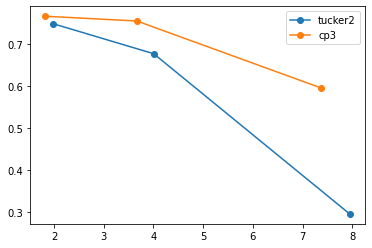

In [78]:
# Plot and analyze results

plt.plot(flops_ratio_tucker2_list, top1_acc_tucker2_list, marker='o', label='tucker2')
plt.plot(flops_ratio_cp3_list, top1_acc_cp3_list, marker='o', label='cp3')

plt.legend()

plt.show()

# Task 5: Bonus task [1 pts]

In Task 2, initialize weights of decomposed layer by using factors from tensor decomposition instead of random initialization.

- Hint: you can see how to perform correct factor reshapes needed for weights initialization in the seminar